<a href="https://colab.research.google.com/github/tonigarrett2023/FinalProject/blob/main/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNetB0 model with pre-trained weights on the ImageNet dataset using Keras. 

In [ ]:
# due to problems with the tensor being serialised to JSON, we have to downgrade to Tensorflow v2.9.1
!pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully unin

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.1


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, matthews_corrcoef, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import shutil
from shutil import copyfile
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import EfficientNetB0
from scipy.ndimage import map_coordinates
import math
import pathlib
import cv2
from matplotlib import cm


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Define paths for the two datasets where dataset1 is Hyperkvasir and dataset2 is CrohnIPI
dataset1_path = "/content/drive/MyDrive/Final_Project/Hyperkvasir_labeled_images/upper_lower_gi_tract"
dataset1_csv = "/content/drive/MyDrive/Final_Project/Hyperkvasir_labeled_images/image-labels.csv"

dataset2_path = '/content/drive/MyDrive/Final_Project/DataCrohnIPI/imgs'
dataset2_csv = '/content/drive/MyDrive/Final_Project/DataCrohnIPI/CrohnIPI_description.csv'

In [ ]:
# Load the CSV files into dataframes previously saved 
merged_labels = pd.read_csv('/content/drive/MyDrive/Final_Project/merged_labels.csv')
merged_df = pd.read_csv('/content/drive/MyDrive/Final_Project/merged_csv')

In [ ]:
merged_labels

filename     Organ  \
0     1fda887e-e41c-4879-8581-3b3668da4ae2  Lower GI   
1     24ea5882-2bce-47fc-819b-96f999be2d55  Lower GI   
2     2a93d2af-50a8-4459-9d4b-5420a6f29a86  Lower GI   
3     34c36057-d7a9-4862-a599-41f764532bd2  Lower GI   
4     35f3d21d-def1-4bec-a96e-9a3906a3de78  Lower GI   
...                                    ...       ...   
4330                             03494.jpg       NaN   
4331                             03495.jpg       NaN   
4332                             03496.jpg       NaN   
4333                             03497.jpg       NaN   
4334                             03498.jpg       NaN   

                                label         Classification  Fold  crohns  \
0        ulcerative-colitis-grade-0-1  pathological-findings   NaN       0   
1        ulcerative-colitis-grade-0-1  pathological-findings   NaN       0   
2        ulcerative-colitis-grade-0-1  pathological-findings   NaN       0   
3        ulcerative-colitis-grade-0-1  pathological-findings   NaN       0   
4        ulcerative-colitis-grade-0-1  pathological-findings   NaN       0   
...                               ...                    ...   ...     ...   
4330                           Normal                    NaN   3.0       0   
4331                         Erythema                    NaN   4.0       1   
4332                           Normal                    NaN   1.0       0   
4333  Ulceration between 3mm and 10mm                    NaN   3.0       1   
4334                           Normal                    NaN   5.0       0   

      uc  normal  
0      1       0  
1      1       0  
2      1       0  
3      1       0  
4      1       0  
...   ..     ...  
4330   0       1  
4331   0       0  
4332   0       1  
4333   0       0  
4334   0       1  

[4335 rows x 8 columns]

In [ ]:
merged_df

file_path  \
0      /content/drive/MyDrive/Final_Project/merged_di...   
1      /content/drive/MyDrive/Final_Project/merged_di...   
2      /content/drive/MyDrive/Final_Project/merged_di...   
3      /content/drive/MyDrive/Final_Project/merged_di...   
4      /content/drive/MyDrive/Final_Project/merged_di...   
...                                                  ...   
14141  /content/drive/MyDrive/Final_Project/merged_di...   
14142  /content/drive/MyDrive/Final_Project/merged_di...   
14143  /content/drive/MyDrive/Final_Project/merged_di...   
14144  /content/drive/MyDrive/Final_Project/merged_di...   
14145  /content/drive/MyDrive/Final_Project/merged_di...   

                            label  
0      ulcerative-colitis-grade-1  
1      ulcerative-colitis-grade-1  
2      ulcerative-colitis-grade-1  
3      ulcerative-colitis-grade-1  
4      ulcerative-colitis-grade-1  
...                           ...  
14141                      Normal  
14142                      Normal  
14143                      Normal  
14144                      Normal  
14145                      Normal  

[14146 rows x 2 columns]

In [ ]:
# Define constants for merged datasets
merged_dir = '/content/drive/MyDrive/Final_Project/merged_dir'

In [ ]:
# define the paths where images are stored 
train_dir = '/content/drive/MyDrive/Final_Project/merged_dir/training_dataset'
val_dir = '/content/drive/MyDrive/Final_Project/merged_dir/validation_dataset'
test_dir = '/content/drive/MyDrive/Final_Project/merged_dir/testing_dataset'

In [ ]:
from pathlib import Path
# Create a Path object from the merged_dir string
merged_dir = Path(merged_dir)

# Get the list of directories in the merged_dir
dirs = [d for d in merged_dir.glob('*') if d.is_dir()]

# Iterate over each directory and get the list of image files
all_files = []
for d in dirs:
    files = [f for f in d.glob('*') if f.is_file() and f.suffix in ['.jpg', '.jpeg', '.png']]
    all_files.extend(files)

# Print the total number of image files found
print(f"Found {len(all_files)} image files")

Found 14146 image files


In [ ]:
# Get the list of directories in the train_dir
classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d)) and d != '.ipynb_checkpoints']
print(classes)

['ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-3', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-0-1', 'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-2', 'dyed-resection-margins', 'dyed-lifted-polyps', 'hemorrhoids', 'polyps', 'retroflex-rectum', 'bbps-0-1', 'barretts-short-segment', 'cecum', 'esophagitis-b-d', 'ileum', 'barretts', 'bbps-2-3', 'esophagitis-a', 'impacted-stool', 'pylorus', 'z-line', 'retroflex-stomach', 'Aphthoid ulceration', 'Erythema', 'Oedema', 'Stenosis', 'Ulceration between 3mm and 10mm', 'Ulceration over 10mm', 'Normal']


In [ ]:
# Get the list of directories in the train_dir
classes = [d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d)) and d != '.ipynb_checkpoints']
print(classes)

['ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-3', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-0-1', 'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-2', 'dyed-resection-margins', 'dyed-lifted-polyps', 'hemorrhoids', 'polyps', 'retroflex-rectum', 'bbps-0-1', 'barretts-short-segment', 'cecum', 'esophagitis-b-d', 'ileum', 'barretts', 'bbps-2-3', 'esophagitis-a', 'impacted-stool', 'pylorus', 'z-line', 'retroflex-stomach', 'Aphthoid ulceration', 'Erythema', 'Oedema', 'Stenosis', 'Ulceration between 3mm and 10mm', 'Ulceration over 10mm', 'Normal']


In [ ]:
# Get the list of directories in the train_dir
classes = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d)) and d != '.ipynb_checkpoints']
print(classes)

['ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-3', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-0-1', 'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-2', 'dyed-resection-margins', 'dyed-lifted-polyps', 'hemorrhoids', 'polyps', 'retroflex-rectum', 'bbps-0-1', 'barretts-short-segment', 'cecum', 'esophagitis-b-d', 'ileum', 'barretts', 'bbps-2-3', 'esophagitis-a', 'impacted-stool', 'pylorus', 'z-line', 'retroflex-stomach', 'Aphthoid ulceration', 'Erythema', 'Oedema', 'Stenosis', 'Ulceration between 3mm and 10mm', 'Ulceration over 10mm', 'Normal']


# Custom Augmentation 
the cutmix function generates a random bounding box for the CutMix patch based on a Beta distribution, rolls the input images and labels along the batch dimension to obtain a second set of images and labels, and then applies CutMix by concatenating the CutMix patches from the two sets of images and labels. The resulting mixed images and labels are returned as the output of the function.

The elastic_transform function takes only the input image as input, and generates a random displacement field using the provided alpha and sigma values. The displacement field is used to index into the input image and generate the output image with elastic deformation.

In [ ]:
# Define the CutMix augmentation function
def cutmix(image, label, alpha=1.0):
    batch_size = tf.shape(image)[0] # Compute the batch size of the input images
    h, w, c = image.shape[1], image.shape[2], image.shape[3] #  Extract the height, width, and number of channels of the input images
    
    # Generate a random bounding box
    lam = np.random.beta(alpha, alpha) # Sample a mixing coefficient from a Beta distribution with parameters 
    bbx1, bby1, bbx2, bby2 = tf.image.sample_bounding_box(tf.shape(image)[1:3], tf.constant([[1. - lam, 1. - lam, lam, lam]])) # Generate a random bounding box for the CutMix patch based on the value of lam
    bbx1, bby1, bbx2, bby2 = tf.cast(bbx1, tf.int32), tf.cast(bby1, tf.int32), tf.cast(bbx2, tf.int32), tf.cast(bby2, tf.int32) # Cast the bounding box coordinates to integers.
    
    # Apply CutMix
    image1 = image # Create a copy of the input images
    label1 = label # Create a copy of the input labels
    image2 = tf.roll(image, shift=batch_size, axis=0) # Roll the input images along the batch dimension by batch_size steps to obtain a second set of images
    label2 = tf.roll(label, shift=batch_size, axis=0) # Roll the input labels along the batch dimension by batch_size steps to obtain a second set of labels
    image = tf.concat([image1[:,bbx1:bbx2,bby1:bby2,:], image2[:,bbx1:bbx2,bby1:bby2,:]], axis=0) # Concatenate the CutMix patches from the two sets of images along the batch dimension to obtain a single set of mixed images
    label = tf.concat([label1, label2], axis=0) # Concatenate the two sets of labels along the batch dimension to obtain a single set of mixed labels
    
    return image, label # Return the mixed images and labels

In [ ]:
# Define the elastic transform function
def elastic_transform(image, alpha, sigma):  
    shape = tf.shape(image) # Compute the shape of the input image tensor
    dx = tf.random.normal(shape, 0, sigma) * alpha # Generate a displacement field in the x-direction by sampling from a Gaussian distribution with mean 0 and standard deviation sigma, and scaling the result by alpha
    dy = tf.random.normal(shape, 0, sigma) * alpha # Generate a displacement field in the y-direction by sampling from a Gaussian distribution with mean 0 and standard deviation sigma, and scaling the result by alpha.
    x, y = tf.meshgrid(tf.range(shape[2]), tf.range(shape[1])) # Generate a grid of x and y pixel coordinates for the input image.
    indices = tf.reshape(x+dx, [-1, 1]), tf.reshape(y+dy, [-1, 1]) # Compute the new pixel coordinates for the output image by adding the displacement fields dx and dy to the original pixel coordinates x and y, and then flattening the resulting tensor to a 2D array of shape (num_pixels, 2) where the first column contains the x-coordinates and the second column contains the y-coordinates.
    return tf.reshape(tf.gather_nd(image, indices), shape) # Use the computed indices to sample from the input image and generate the output image with elastic deformation

In [ ]:
def apply_grid_distortion(image):
    # Define ImageDataGenerator with grid distortion
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.preprocessing.image.apply_grid_distortion(
            0.2, kernel_shape=(3, 3)))

    # Apply grid distortion to image
    distorted_image_tensor = data_gen.flow(tf.expand_dims(image, axis=0)).next()

    # Convert distorted image tensor to array and return it
    distorted_image = distorted_image_tensor[0]
    return distorted_image

# Building the EfficientNetB0 model to detect the class of the image

there are problems with Colab creating .ipynb_checkpoint files which are causing the model to find 31 classes instead of 30 so we will ensure that these are not included. 

In [ ]:
batch_size  = 32
img_size = (224, 224)

# Define augmentation parameters
rotation_range = 20
width_shift_range = 0.1
height_shift_range = 0.1
shear_range = 0.2
zoom_range = 0.2
horizontal_flip = True
vertical_flip = True
brightness_range = [0.8, 1.2]


# Loop through the directory paths and remove the .ipynb_checkpoints directories
for dir_path in [train_dir, val_dir, test_dir]:
    checkpoint_path = os.path.join(dir_path, '.ipynb_checkpoints')
    if os.path.exists(checkpoint_path):
        os.rmdir(checkpoint_path)


# Define ImageDataGenerator with augmentation parameters
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=rotation_range,
                                                                width_shift_range=width_shift_range,
                                                                height_shift_range=height_shift_range,
                                                                shear_range=shear_range,
                                                                zoom_range=zoom_range,
                                                                horizontal_flip=horizontal_flip,
                                                                vertical_flip=vertical_flip,
                                                                brightness_range=brightness_range,
                                                                preprocessing_function=[
                                                                    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
                                                                    tf.keras.layers.experimental.preprocessing.RandomRotation(20),
                                                                    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2))
                                                                ])

# Get the list of subdirectories in the train directory
train_classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d)) and d != '.ipynb_checkpoints']

# Define ImageDataGenerator without augmentation for validation and testing
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

# Load the dataset from directory
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                       labels='inferred',
                                                       label_mode='categorical',
                                                       batch_size=batch_size,
                                                       image_size=img_size,
                                                       shuffle=True,
                                                       seed=42,
                                                       class_names=train_classes
                                                       )

# Get the list of subdirectories in the validation directory
val_classes = [d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d)) and d != '.ipynb_checkpoints']

val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                     labels='inferred',
                                                     label_mode='categorical',
                                                     batch_size=batch_size,
                                                     image_size=img_size,
                                                     shuffle=True,
                                                     seed=42,
                                                     class_names=val_classes
                                                     )
                                                    

# Get the list of subdirectories in the test directory
test_classes = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d)) and d != '.ipynb_checkpoints']

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      labels='inferred',
                                                      label_mode='categorical',
                                                      batch_size=batch_size,
                                                      image_size=img_size,
                                                      shuffle=False,
                                                      seed=42,
                                                      class_names=test_classes
                                                      )
                                                    

Found 9902 files belonging to 30 classes.
Found 2122 files belonging to 30 classes.
Found 2122 files belonging to 30 classes.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 3)
validation_dataset = val_ds.skip(val_batches // 3)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 45
Number of test batches: 22


In [ ]:
# Rescale pixel values to [0, 1]
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))


The AUTOTUNE constant is a special value that allows TensorFlow to automatically determine the optimal buffer size at runtime. When using prefetching, TensorFlow will try to fetch batches of data from disk while the model is still training on the previous batch. This can significantly speed up the training process since the model won't have to wait for disk I/O.

prefetch(buffer_size=AUTOTUNE) is a method of the tf.data.Dataset class which adds a prefetching step to the dataset pipeline. This means that while the GPU is processing the current batch, the CPU will be fetching the next batch of data from disk, ensuring that there is always a steady stream of data being fed to the model. The buffer_size parameter determines how many elements should be prefetched at a time. The AUTOTUNE value allows TensorFlow to automatically determine the optimal buffer size at runtime based on available system resources.

By adding prefetching to the dataset pipeline, we can reduce the idle time of the GPU and improve overall training efficiency.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
# Define input shape
input_shape = (224, 224, 3)

# Load pre-trained EfficientNetB0 model without top layer
base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# number of classes
num_classes = len(classes)

# Add custom top layers for classification
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Define the model
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Train the model and save history
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

# Save the model
model.save('/content/drive/MyDrive/Final_Project/Models/Effnet_model1.h5')

Epoch 1/15
310/310 [==============================] - 197s 637ms/step - loss: 0.5681 - accuracy: 0.8097 - val_loss: 0.5910 - val_accuracy: 0.7950
Epoch 2/15
310/310 [==============================] - 20s 63ms/step - loss: 0.4493 - accuracy: 0.8416 - val_loss: 0.5749 - val_accuracy: 0.8058
Epoch 3/15
310/310 [==============================] - 20s 62ms/step - loss: 0.3777 - accuracy: 0.8692 - val_loss: 0.5039 - val_accuracy: 0.8289
Epoch 4/15
310/310 [==============================] - 20s 62ms/step - loss: 0.3383 - accuracy: 0.8782 - val_loss: 0.5459 - val_accuracy: 0.8167
Epoch 5/15
310/310 [==============================] - 19s 62ms/step - loss: 0.2980 - accuracy: 0.8883 - val_loss: 0.5603 - val_accuracy: 0.8233
Epoch 6/15
310/310 [==============================] - 20s 63ms/step - loss: 0.2789 - accuracy: 0.9012 - val_loss: 0.5745 - val_accuracy: 0.8205
Epoch 7/15
310/310 [==============================] - 19s 61ms/step - loss: 0.2446 - accuracy: 0.9118 - val_loss: 0.5919 - val_accurac

# Fine Tuning of the model

In [ ]:
# How many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  238


In [ ]:
# Unfreeze some layers of the base model
base_model.trainable = True
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [ ]:
# compile the model again with a lower learning rate, to make sure that the fine-tuned weights do not get updated too quickly and 
# destabilize the previously learned features
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 35
total_epochs =  15 + fine_tune_epochs

history_fine_tune = model.fit(train_ds,
                              epochs=total_epochs,
                              initial_epoch=history.epoch[-1],
                              validation_data=val_ds,
                              )

# Save the model
model.save('/content/drive/MyDrive/Final_Project/Models/Effnet_model1_finetuned.h5')

Epoch 15/50
310/310 [==============================] - 67s 184ms/step - loss: 2.2227 - accuracy: 0.6118 - val_loss: 1.3160 - val_accuracy: 0.7385
Epoch 16/50
310/310 [==============================] - 55s 177ms/step - loss: 1.0844 - accuracy: 0.7399 - val_loss: 1.0949 - val_accuracy: 0.7653
Epoch 17/50
310/310 [==============================] - 55s 177ms/step - loss: 0.7823 - accuracy: 0.7912 - val_loss: 0.9599 - val_accuracy: 0.7917
Epoch 18/50
310/310 [==============================] - 55s 177ms/step - loss: 0.6320 - accuracy: 0.8170 - val_loss: 0.8818 - val_accuracy: 0.7983
Epoch 19/50
310/310 [==============================] - 56s 178ms/step - loss: 0.5385 - accuracy: 0.8317 - val_loss: 0.8213 - val_accuracy: 0.8091
Epoch 20/50
310/310 [==============================] - 56s 178ms/step - loss: 0.4473 - accuracy: 0.8601 - val_loss: 0.7799 - val_accuracy: 0.8181
Epoch 21/50
310/310 [==============================] - 55s 177ms/step - loss: 0.3939 - accuracy: 0.8694 - val_loss: 0.7514 -

# What does augmentation look like? 

Unfortunately, I did not save the augmented images into a directory but we can calculate the total number of possible image variations per original image as:

Rotation: 40 variations (20 degrees clockwise and 20 degrees counterclockwise)
Width shift: 11 variations (10% shift in each direction and no shift)
Height shift: 11 variations (10% shift in each direction and no shift)
Shear: 5 variations
Zoom: 5 variations
Horizontal flip: 2 variations (original and flipped)
Vertical flip: 2 variations (original and flipped)
Brightness: 5 variations
Therefore, the total number of possible image variations per original image is:

40 x 11 x 11 x 5 x 5 x 2 x 2 x 5 = 4,620,000

The original number of images was 14,146 in total. 

However, it's important to note that not all possible image variations will actually be generated since the augmentation is randomized. The actual number of images generated will depend on the number of original images in the dataset and the augmentation parameters used, which unfortunately, we cannot verify. 

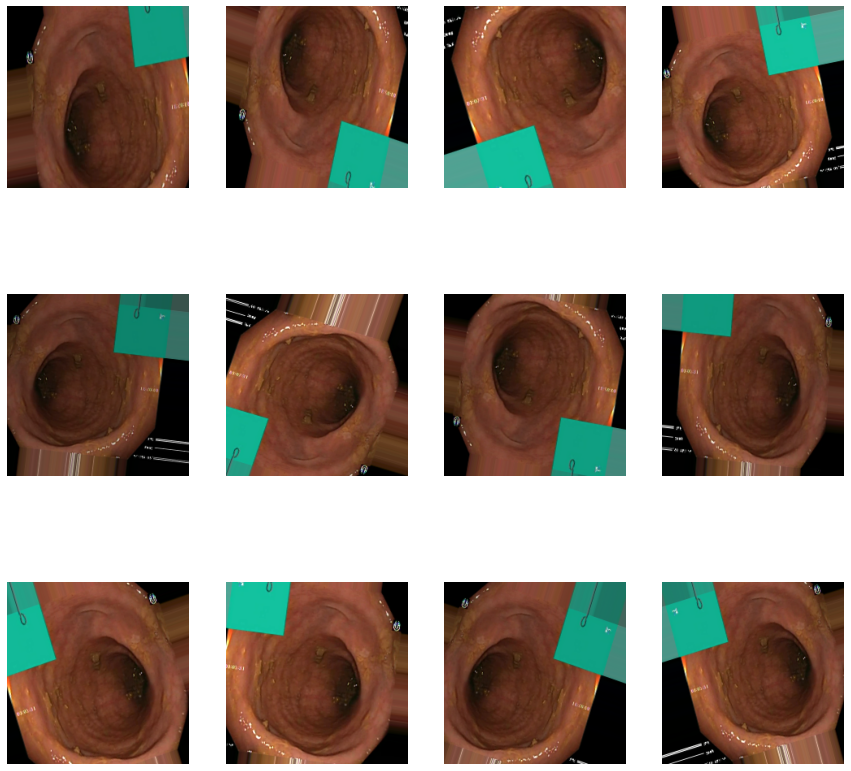

In [ ]:
# Get a random image from train_ds
for image, _ in train_ds.take(1):
    random_image = image[0]

# Display the augmented versions of the random image
plt.figure(figsize=(15, 15))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    augmented_image = train_datagen.random_transform(random_image.numpy())
    plt.imshow(augmented_image / 255.)
    plt.axis('off')
plt.show()

# Evaluation of the Model

In [ ]:
scores = model.evaluate(test_ds)

67/67 [==============================] - 46s 688ms/step - loss: 0.6026 - accuracy: 0.8553


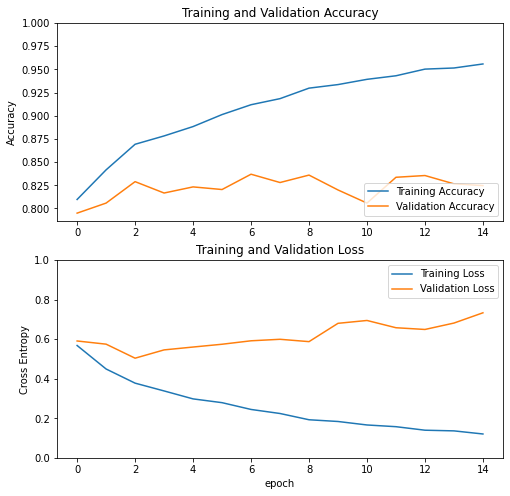

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

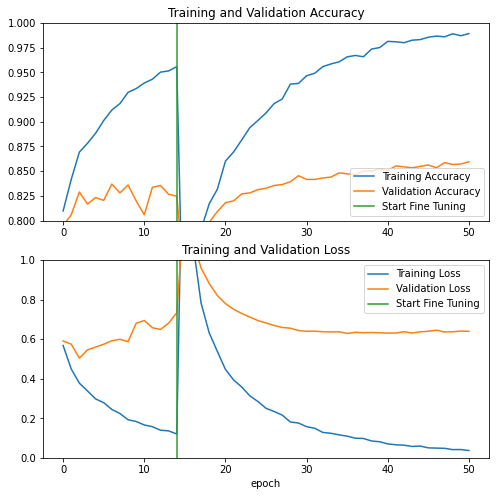

In [ ]:
# after fine tuning the model 
acc += history_fine_tune.history['accuracy']
val_acc += history_fine_tune.history['val_accuracy']

loss += history_fine_tune.history['loss']
val_loss += history_fine_tune.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([15-1,15-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([15-1,15-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluate the model on the validation set
y_val_true = []
y_val_pred = []
for images, labels in val_ds:
    y_val_true.extend(tf.argmax(labels, axis=1).numpy())
    y_val_pred.extend(tf.argmax(model.predict(images), axis=1).numpy())
print('Validation set classification report:\n', classification_report(y_val_true, y_val_pred))
print('Validation set confusion matrix:\n', confusion_matrix(y_val_true, y_val_pred))

1/1 [==============================] - 1s 1s/step
Validation set classification report:
               precision    recall  f1-score   support

           0       0.45      0.50      0.48        30
           1       0.56      0.45      0.50        20
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         4
           5       0.63      0.74      0.68        66
           6       0.87      0.84      0.86       148
           7       0.86      0.87      0.86       150
           8       0.00      0.00      0.00         1
           9       0.97      0.97      0.97       154
          10       0.92      0.97      0.94        59
          11       0.98      0.96      0.97        97
          12       0.00      0.00      0.00         8
          13       0.97      0.97      0.97       152
          14       0.67      0.51      0.58        39
          15       0.00      0.00      0.00   

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Evaluate the model on the test set
y_test_true = []
y_test_pred = []
for images, labels in test_ds:
    y_test_true.extend(tf.argmax(labels, axis=1).numpy())
    y_test_pred.extend(tf.argmax(model.predict(images), axis=1).numpy())
print('Test set classification report:\n', classification_report(y_test_true, y_test_pred))
print('Test set confusion matrix:\n', confusion_matrix(y_test_true, y_test_pred))


1/1 [==============================] - 0s 30ms/step
Test set classification report:
               precision    recall  f1-score   support

           0       0.36      0.27      0.31        30
           1       0.78      0.70      0.74        20
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         4
           5       0.64      0.73      0.68        67
           6       0.87      0.87      0.87       149
           7       0.89      0.85      0.87       151
           8       0.00      0.00      0.00         1
           9       0.99      0.94      0.97       154
          10       0.92      0.98      0.95        58
          11       0.99      0.97      0.98        97
          12       0.00      0.00      0.00         8
          13       0.93      0.99      0.96       151
          14       0.61      0.56      0.59        39
          15       0.00      0.00      0.00       

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Observations on the classification report above: 

The classification report shows the precision, recall, and F1-score for each class, as well as the support (number of samples) for each class. From the report, it seems that some classes have very low precision, recall, and F1-score, such as class 0, class 2, class 3, class 4, class 8, class 12, class 15, and class 16. This may indicate that the model is having difficulty distinguishing these classes. On the other hand, some classes have high precision, recall, and F1-score, such as class 6, class 7, class 9, class 10, class 11, class 13, class 17, class 20, class 21, class 22, class 27, class 28, and class 29. This suggests that the model is performing well for these classes. Overall, the weighted average F1-score is 0.85, which indicates that the model is performing reasonably well on the test set. However, it is important to further analyze the confusion matrix and consider other metrics to fully evaluate the model's performance.

# Confusion Matrix heatmap

In a confusion matrix heatmap, the diagonal represents the correctly classified samples, while the off-diagonal elements represent the misclassifications. Here, off-diagonal colors are light and most of the diagonal is medium to darker in colour, it means that there are fewer misclassifications, and most of the samples are classified correctly. The lighter color of the off-diagonal elements indicates that the misclassifications are relatively low, and the darker color of the diagonal elements indicates that most of the samples are classified correctly. This is a good sign, as it suggests that the model is performing well and accurately classifying the images.

67/67 [==============================] - 3s 45ms/step


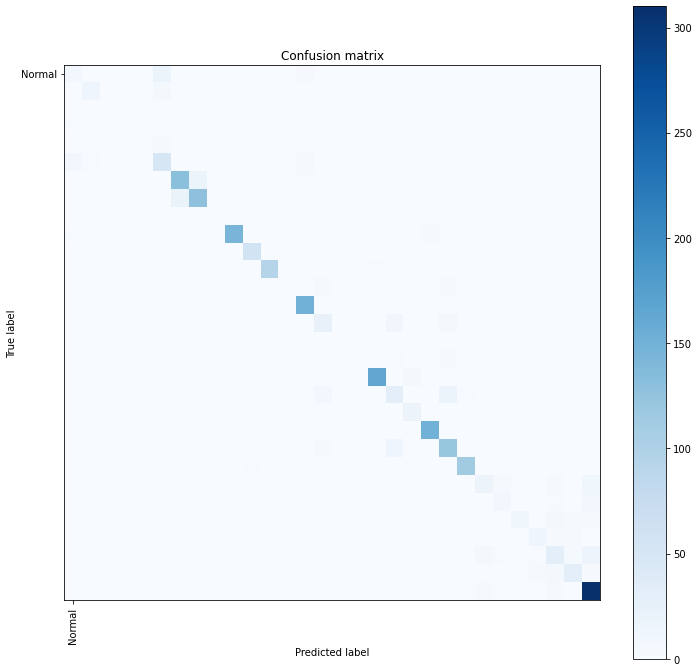

In [ ]:
# Calculate the confusion matrix
y_pred = model.predict(test_ds)
y_true = np.concatenate([tf.argmax(labels.numpy(), axis=1) for _, labels in test_ds], axis=0)
y_pred_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(12,12))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

67/67 [==============================] - 3s 40ms/step


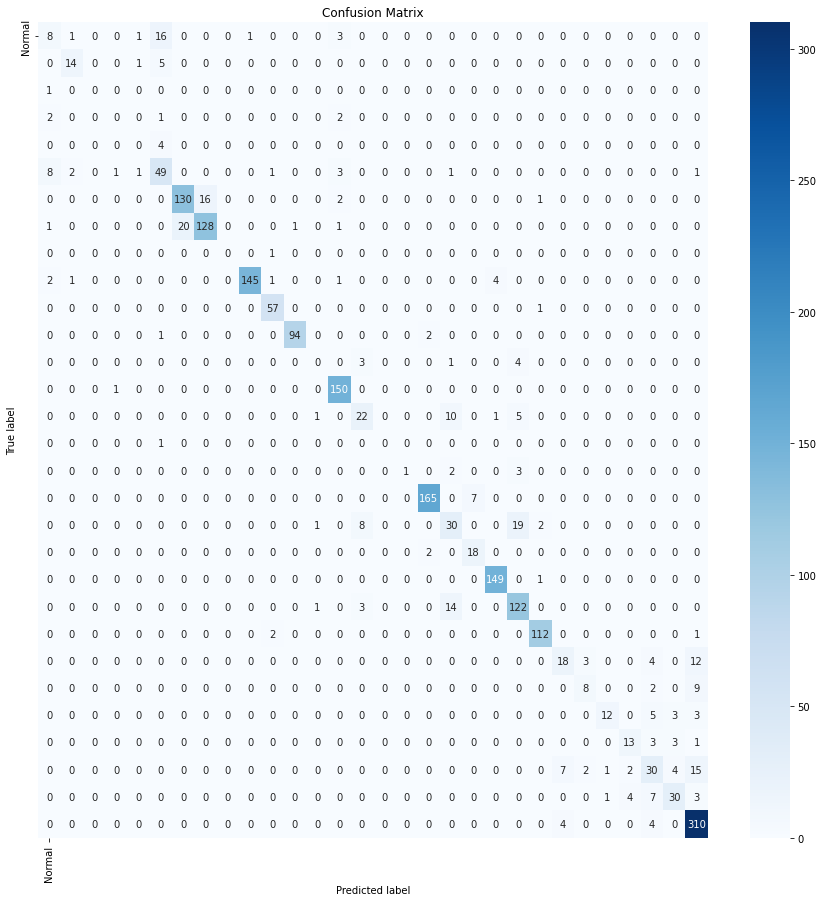

In [ ]:
# Get the true labels and predicted labels
y_true = np.concatenate([tf.argmax(labels.numpy(), axis=1) for _, labels in test_ds], axis=0)
y_pred = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xticks(np.arange(len(classes)) + 0.5, classes, rotation=90)
plt.yticks(np.arange(len(classes)) + 0.5, classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

67/67 [==============================] - 3s 39ms/step


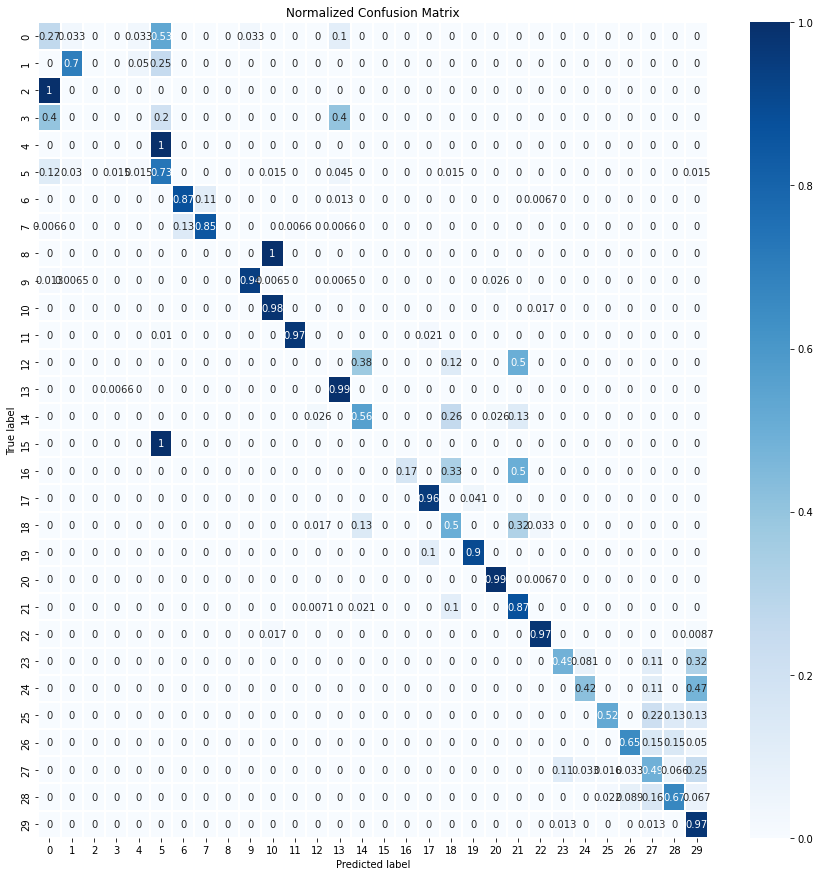

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
y_pred = model.predict(test_ds)
y_true = np.concatenate([tf.argmax(labels.numpy(), axis=1) for _, labels in test_ds], axis=0)
y_pred_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_labels)

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(15,15))
sns.heatmap(cm_norm, annot=True, cmap='Blues', linewidths = 0.01)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


# ROC AUC 

In a multi-class classification problem, the ROC AUC score can be calculated for each class separately, and the micro-average can be used to aggregate the scores for all the classes. The micro-average is the average of the individual true positive, false positive, and false negative rates across all classes.

The results of the ROC AUC scores provide insight into how well the model is performing for each individual class and the overall performance of the model. The higher the AUC score, the better the model is at distinguishing between the positive and negative classes. The micro-average AUC score provides an overall measure of how well the model is performing across all classes.

The micro-average AUC score of 0.925 indicates that overall, the model has good discrimination ability in predicting the binary outcome of the classes. The micro-average AUC score takes into account all the true positives, false positives, true negatives and false negatives across all classes and provides an overall score for the model.

The macro-average AUC score of 0.788 indicates the average performance of the model in predicting the binary outcome of each individual class. A macro-average calculates the average performance of the model on a per-class basis, without taking into account the frequency of each class in the dataset.



1/1 [==============================] - 0s 32ms/step


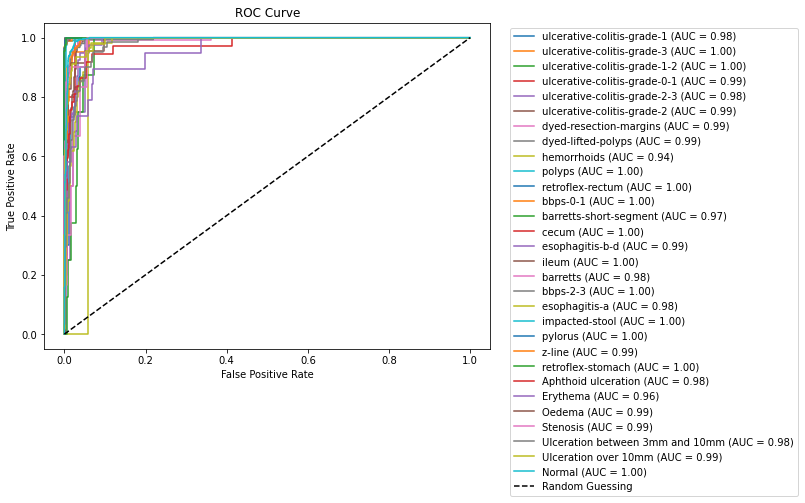

In [ ]:
# Calculate the ROC curve and AUC score for each class
y_test_true = []
y_test_pred = []
for images, labels in test_ds:
    y_test_true.extend(tf.argmax(labels, axis=1).numpy())
    y_test_pred.extend(model.predict(images))
y_test_true = np.array(y_test_true)
y_test_pred = np.array(y_test_pred)
num_classes = len(classes)

# Calculate the ROC curve and AUC score for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(tf.keras.utils.to_categorical(y_test_true)[:, i], 
                                   y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve and AUC score for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(bbox_to_anchor=(1.7, 1), loc='upper right')
plt.show()

In [ ]:
# Calculate micro-average AUC score on the test set
y_test_true_binary = tf.keras.utils.to_categorical(y_test_true)
y_test_pred_binary = tf.keras.utils.to_categorical(np.argmax(y_test_pred, axis=1))
micro_auc = roc_auc_score(y_test_true_binary.ravel(), y_test_pred_binary.ravel(), average='micro')

# Calculate macro-average AUC score
macro_auc = roc_auc_score(y_test_true_binary, y_test_pred_binary, average='macro')

print('Micro-average AUC score:', micro_auc)
print('Macro-average AUC score:', macro_auc)

Micro-average AUC score: 0.9251681887614157
Macro-average AUC score: 0.7882135426848049


The AUC score for each class and the micro-average can be calculated on either the validation set or the test set. It is common to use the validation set to evaluate the performance of the model during development and hyperparameter tuning, as I have shown below, and then use the test set to get a final evaluation of the model performance after all the development is done.

In [ ]:
# Print the AUC score for each class and the micro-average in teh Validation Set

# Get the true labels and predicted probabilities for the validation set
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_prob = model.predict(val_ds)

# Calculate the AUC score for each class and the micro-average
auc_scores = roc_auc_score(y_true, y_prob, average=None)
micro_avg_auc = roc_auc_score(y_true, y_prob, average='micro')

# Create a pandas dataframe with the AUC scores
df = pd.DataFrame({"Class": classes, "AUC Score": auc_scores})

# Add the micro-average AUC score to the dataframe
df = df.append({"Class": "Micro-average", "AUC Score": micro_avg_auc}, ignore_index=True)

# Print the dataframe
print(df)

# Print the AUC score for each class and the micro-average
# for i, cls in enumerate(classes):
#     print(f"AUC score for {cls}: {auc_scores[i]}")
# print(f"Micro-average AUC score: {micro_avg_auc}")

67/67 [==============================] - 3s 45ms/step
                              Class  AUC Score
0        ulcerative-colitis-grade-1   0.457584
1        ulcerative-colitis-grade-3   0.429091
2      ulcerative-colitis-grade-1-2   0.275943
3      ulcerative-colitis-grade-0-1   0.496219
4      ulcerative-colitis-grade-2-3   0.602691
5        ulcerative-colitis-grade-2   0.502314
6            dyed-resection-margins   0.514939
7                dyed-lifted-polyps   0.503169
8                       hemorrhoids   0.352664
9                            polyps   0.528271
10                 retroflex-rectum   0.497934
11                         bbps-0-1   0.477083
12           barretts-short-segment   0.405038
13                            cecum   0.479622
14                  esophagitis-b-d   0.374608
15                            ileum   0.840802
16                         barretts   0.646818
17                         bbps-2-3   0.492579
18                    esophagitis-a   0.498898
19    

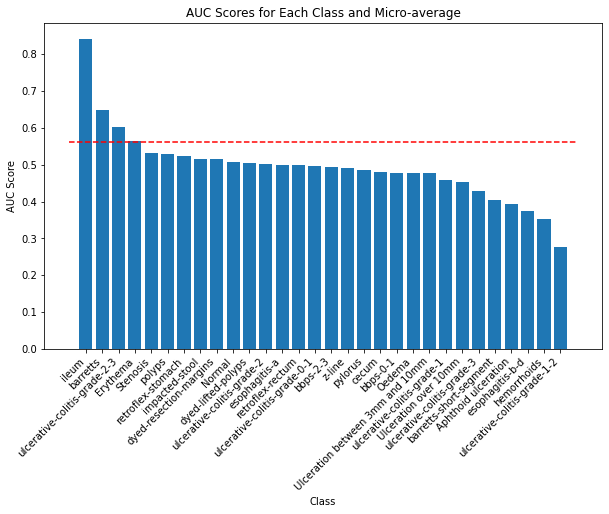

In [ ]:
# Get the classes and sort the AUC scores in descending order
sorted_classes = [cls for _, cls in sorted(zip(auc_scores, classes), reverse=True)]
sorted_auc_scores = np.sort(auc_scores)[::-1]

# Plot the bar graph and line for micro-average
plt.figure(figsize=(10,6))
plt.bar(sorted_classes, sorted_auc_scores)
plt.plot([-1, len(classes)], [micro_avg_auc, micro_avg_auc], 'r--')
plt.xticks(rotation=45, ha='right')
plt.title("AUC Scores for Each Class and Micro-average")
plt.xlabel("Class")
plt.ylabel("AUC Score")
plt.show()

1/1 [==============================] - 0s 37ms/step


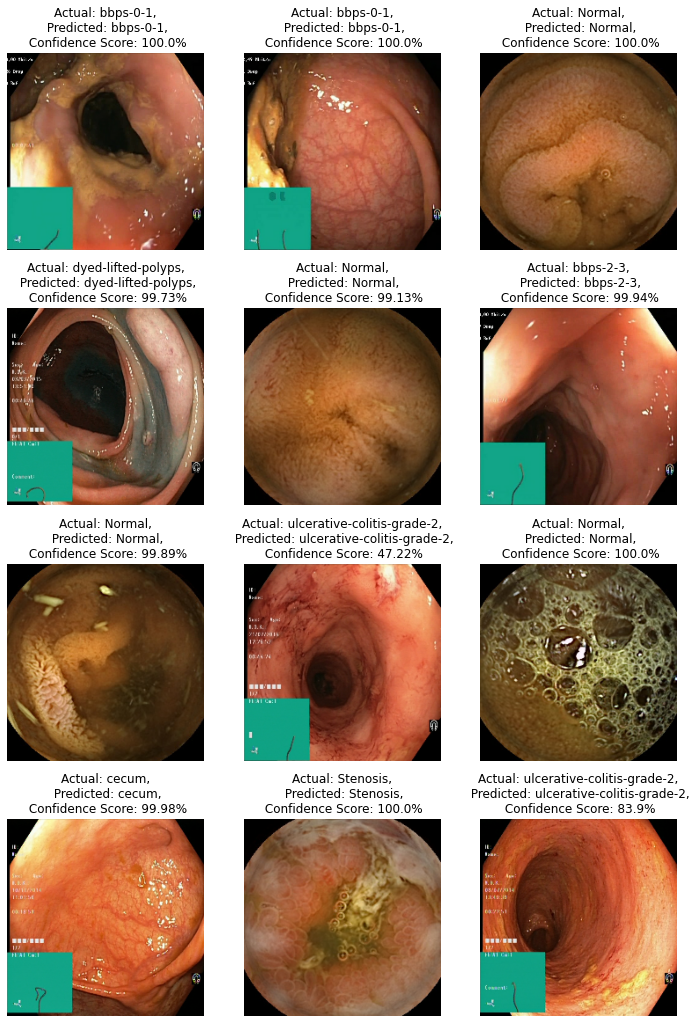

In [ ]:
# PREDICTIONS
BATCH_SIZE = 12
plt.figure(figsize=(12, 18))
for images, labels in val_ds.take(1):
   for i in range(BATCH_SIZE):
      ax = plt.subplot(4, 3, i + 1)
      plt.imshow(images[i].numpy().astype('uint8'))
      actual_cls = classes[tf.argmax(labels[i]).numpy()]
      prediction = model.predict(images)
      predicted_cls = classes[np.argmax(prediction[i])]
      confidence = round(100 * (np.max(prediction[i])), 2)
      plt.title(f"Actual: {actual_cls},\n Predicted: {predicted_cls},\n Confidence Score: {confidence}%")
      plt.axis("off")

# Generating heatmaps for Explainable AI 

Heatmaps are a useful tool for interpreting the output of a convolutional neural network (CNN), particularly when it comes to image classification tasks. When a CNN makes a prediction about an image, it does so based on a combination of features that it has learned from the training data. These features are often abstract and difficult to interpret in isolation, but by visualizing them in the form of a heatmap, we can gain a better understanding of what the CNN is looking for when it makes a prediction.

The heatmap is generated by calculating the gradient of the output of the last convolutional layer with respect to the predicted class. This gradient indicates how much each pixel in the input image contributes to the predicted class, and can be visualized as a heatmap overlaid on the original image. The areas of the image that are most important for the prediction will be highlighted in the heatmap, making it easier to understand why the CNN has made the prediction that it has.

In medical image classification tasks, heatmaps can be particularly useful for interpreting the output of a CNN, as they can help doctors and medical professionals to understand how the model is arriving at its predictions. For example, in a classification task involving X-rays or other medical images, a heatmap can help to highlight the regions of an image that are most important for the model when it is making a diagnosis. This can help medical professionals to better understand the underlying pathology of the disease, and to make more informed treatment decisions based on the model's predictions.

Here, I have taken the last 2 convolutional layers to display and visualise what the model is using to make its prediction. 

In [ ]:
# Define a function to generate the heatmaps using Grad-CAM
def generate_heatmap(model, img_tensor, last_conv_layer_name):
    # Extract the last convolutional layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    # Create a model that outputs the last convolutional layer's output and the model output
    grad_model = tf.keras.models.Model(
        [model.inputs], [last_conv_layer.output, model.output]
    )
    # Get the gradients of the predicted class with respect to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_tensor)
        loss = predictions[:, tf.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_output)
    # Compute the channel-wise average of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # Multiply each channel by its corresponding gradient average
    last_conv_layer_output = conv_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    return heatmap


In [ ]:
# Define the batch size and the last convolutional layer name
BATCH_SIZE = 12
LAST_CONV_LAYER_NAME_opt1 = 'top_conv'
LAST_CONV_LAYER_NAME_opt2 = 'block7a_project_conv'
num_rows = 4

1/1 [==============================] - 0s 37ms/step


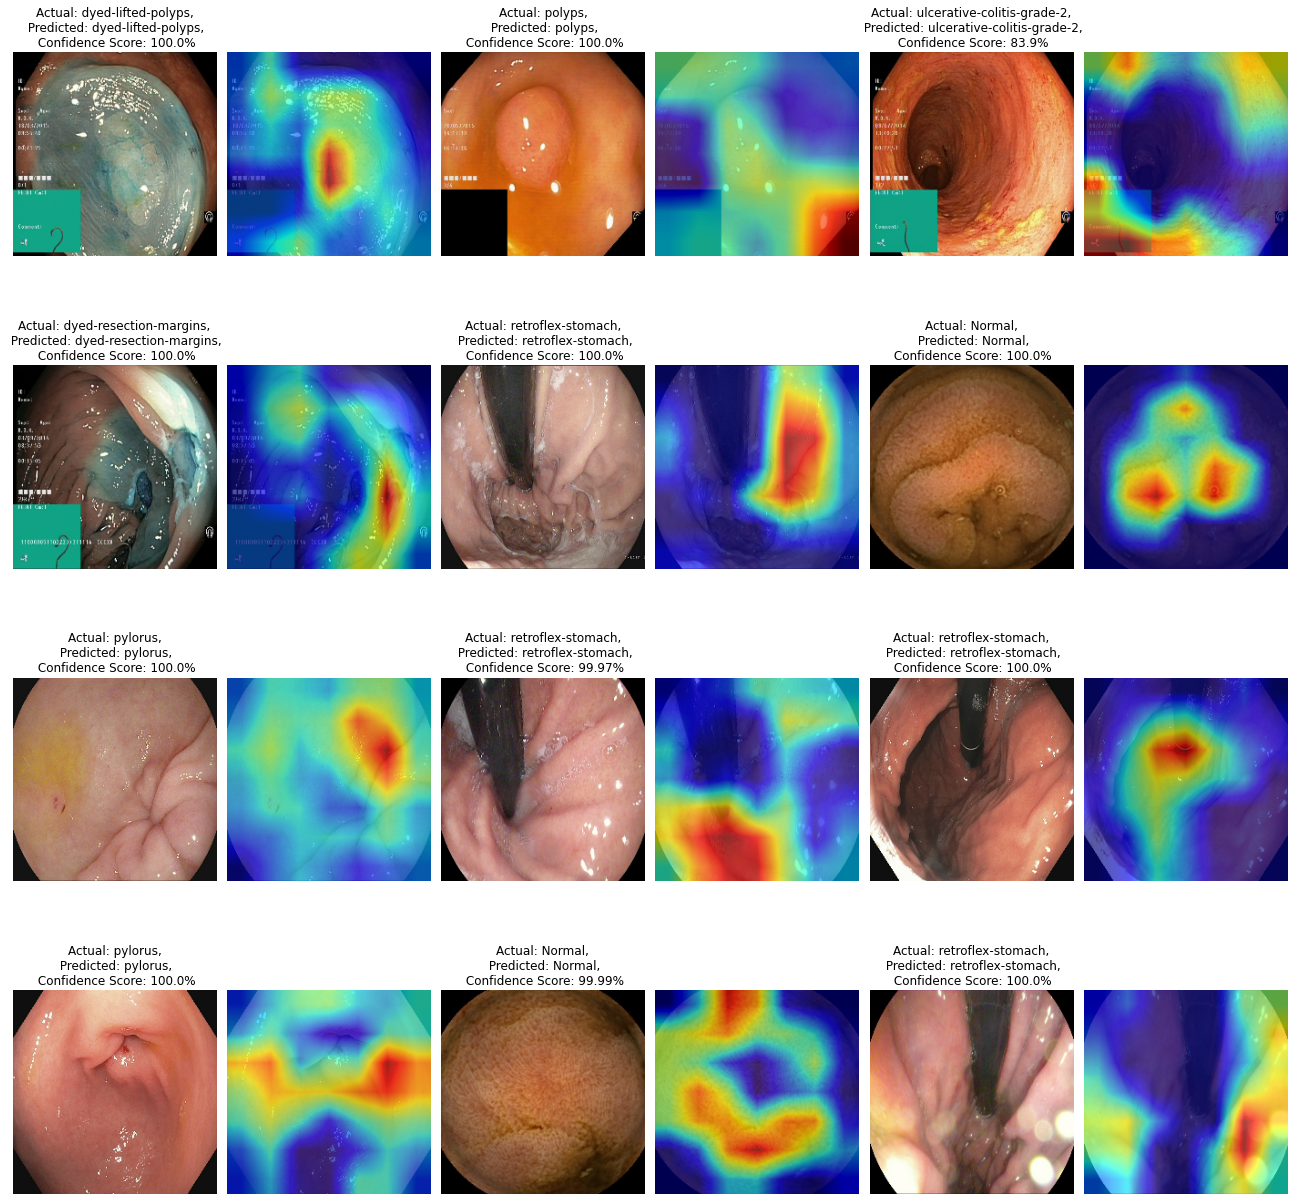

In [ ]:
# Generate the heatmaps and display the images with their predicted classes and heatmaps
plt.figure(figsize=(18, 18))

for images, labels in val_ds.take(1):
    for i in range(BATCH_SIZE):
        # Calculate the row and column index based on the index of the current image
        row = i // 3
        col = i % 3
        
        # Display the original image and its predicted class
        ax = plt.subplot(num_rows, 6, row*6 + col*2 + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        actual_cls = classes[tf.argmax(labels[i]).numpy()]
        prediction = model.predict(images)
        predicted_cls = classes[np.argmax(prediction[i])]
        confidence = round(100 * (np.max(prediction[i])), 2)
        plt.title(f"Actual: {actual_cls},\n Predicted: {predicted_cls},\n Confidence Score: {confidence}%")
        plt.axis("off")
    
        # Generate the heatmap and display it
        heatmap = generate_heatmap(model, images[i][tf.newaxis], LAST_CONV_LAYER_NAME_opt1)
        heatmap = cv2.resize(heatmap, (images[i].shape[1], images[i].shape[0]))
        heatmap = np.uint8(255 * heatmap)
        jet_heatmap = cm.jet(heatmap)
        jet_heatmap = np.delete(jet_heatmap, 3, 2)
        ax = plt.subplot(num_rows, 6, row*6 + col*2 + 2)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.imshow(jet_heatmap, alpha=0.65)
        plt.axis("off")

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 42ms/step


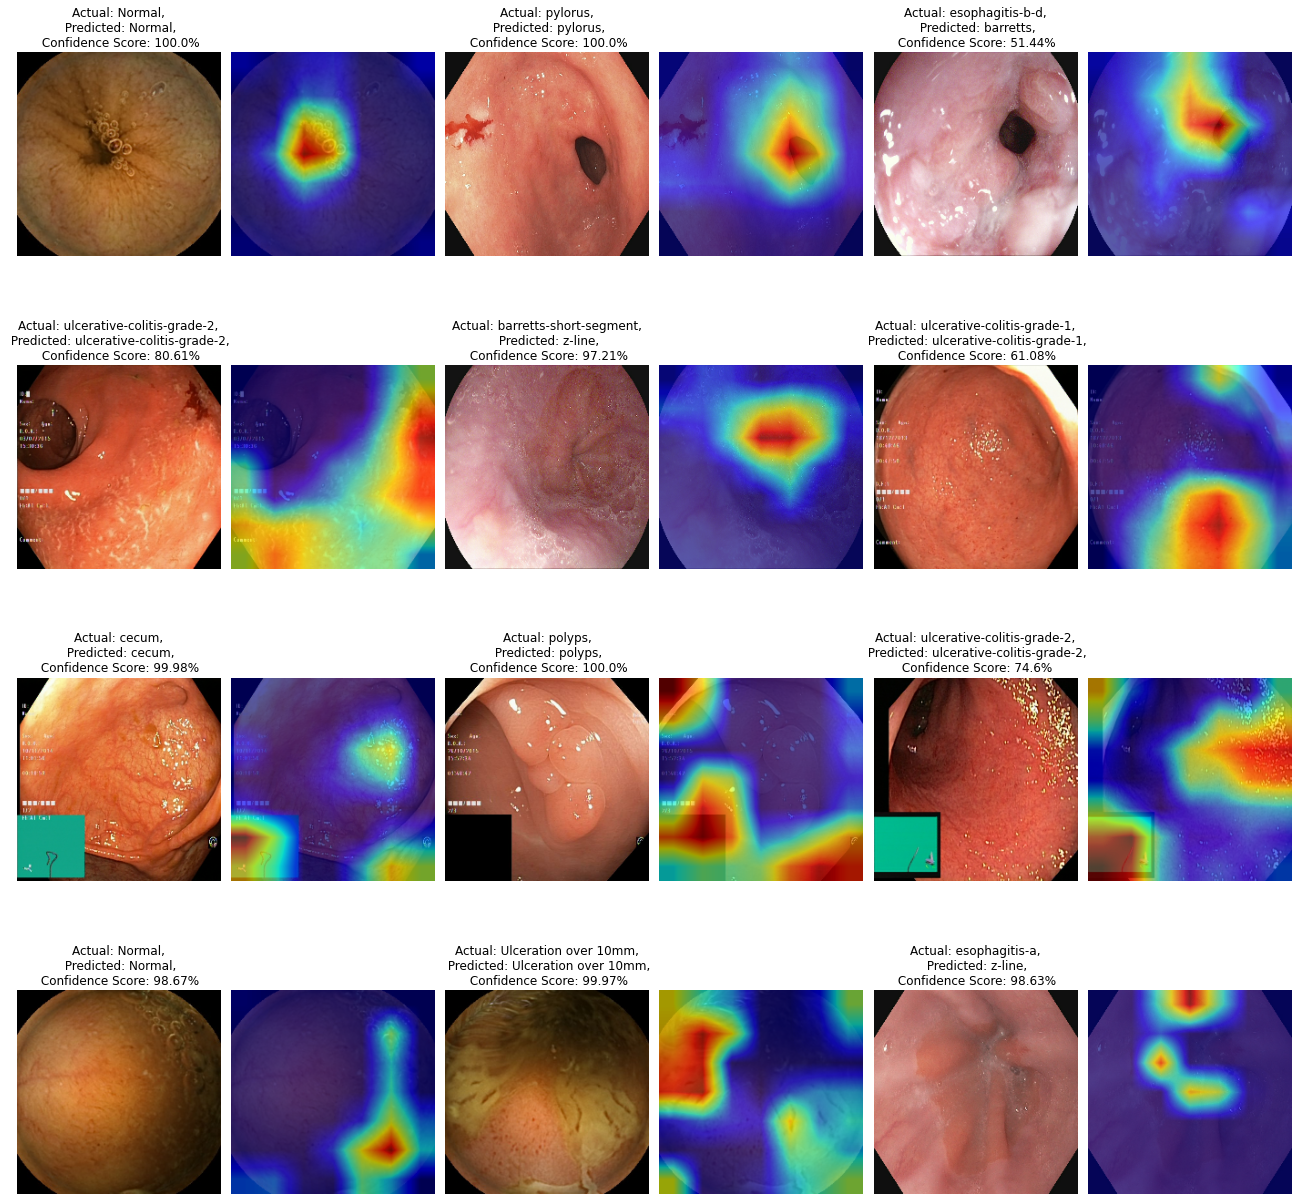

In [ ]:
# Generate the heatmaps and display the images with their predicted classes and heatmaps
plt.figure(figsize=(18, 18))

for images, labels in val_ds.take(1):
    for i in range(BATCH_SIZE):
        # Calculate the row and column index based on the index of the current image
        row = i // 3
        col = i % 3
        
        # Display the original image and its predicted class
        ax = plt.subplot(num_rows, 6, row*6 + col*2 + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        actual_cls = classes[tf.argmax(labels[i]).numpy()]
        prediction = model.predict(images)
        predicted_cls = classes[np.argmax(prediction[i])]
        confidence = round(100 * (np.max(prediction[i])), 2)
        plt.title(f"Actual: {actual_cls},\n Predicted: {predicted_cls},\n Confidence Score: {confidence}%")
        plt.axis("off")
    
        # Generate the heatmap and display it
        heatmap = generate_heatmap(model, images[i][tf.newaxis], LAST_CONV_LAYER_NAME_opt2)
        heatmap = cv2.resize(heatmap, (images[i].shape[1], images[i].shape[0]))
        heatmap = np.uint8(255 * heatmap)
        jet_heatmap = cm.jet(heatmap)
        jet_heatmap = np.delete(jet_heatmap, 3, 2)
        ax = plt.subplot(num_rows, 6, row*6 + col*2 + 2)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.imshow(jet_heatmap, alpha=0.65)
        plt.axis("off")

plt.tight_layout()
plt.show()



# What is a Normal class?

These are images of a disease free gastrointestinal tract and further researching this would give insights into what the model considers as normal features in the images. By analysing the model's behaviour and output for the Normal class can help researchers gain insights into what a healthy gastrointestinal image looks like which could be useful in developing new diagnostic tools or improving existing ones. 

In [ ]:
# Create a new dataset with only the Normal class images 
train_data_gen = ImageDataGenerator(rescale=1./255)  # normalize the pixel values
normal_merged_ds = train_data_gen.flow_from_directory(directory=merged_dir,
                                                     target_size=(224, 224),
                                                     class_mode='categorical',
                                                     classes=['Normal'],
                                                     batch_size=32,
                                                     shuffle=True
                                                     )

Found 2124 images belonging to 1 classes.


In [ ]:
# Create a new dataset with only the Normal class images 
train_data_gen = ImageDataGenerator(rescale=1./255)  # normalize the pixel values
normal_train_ds = train_data_gen.flow_from_directory(directory=train_dir,
                                                     target_size=(224, 224),
                                                     class_mode='categorical',
                                                     classes=['Normal'],
                                                     batch_size=32,
                                                     shuffle=True
                                                     )

Found 1487 images belonging to 1 classes.


In [ ]:
# Make predictions with the model using the test data iterator
predictions = model.predict(test_ds)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

67/67 [==============================] - 3s 38ms/step


1/1 [==============================] - 0s 28ms/step


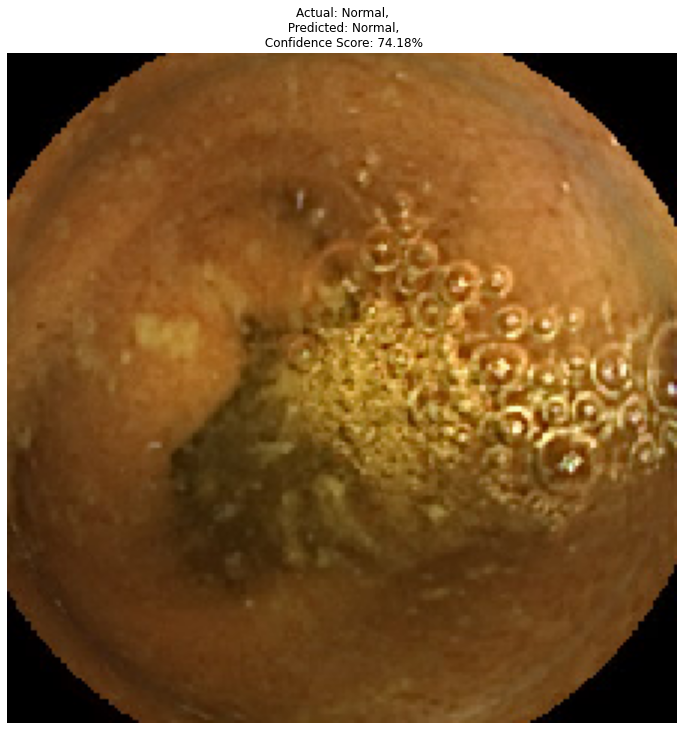

In [ ]:
BATCH_SIZE = 12
plt.figure(figsize=(12, 18))
for images, labels in normal_train_ds:
    for i in range(BATCH_SIZE):
        img = images[i]
        plt.imshow(img)
        actual_cls = 'Normal'  # since we only have images from the Normal class
        prediction = model.predict(img[np.newaxis, ...])
        predicted_cls = 'Normal'
        confidence = round(100 * (np.max(prediction)), 2)
        plt.title(f"Actual: {actual_cls},\n Predicted: {predicted_cls},\n Confidence Score: {confidence}%")
        plt.axis("off")
    break  # break after the first batch to avoid displaying too many images






1/1 [==============================] - 0s 30ms/step


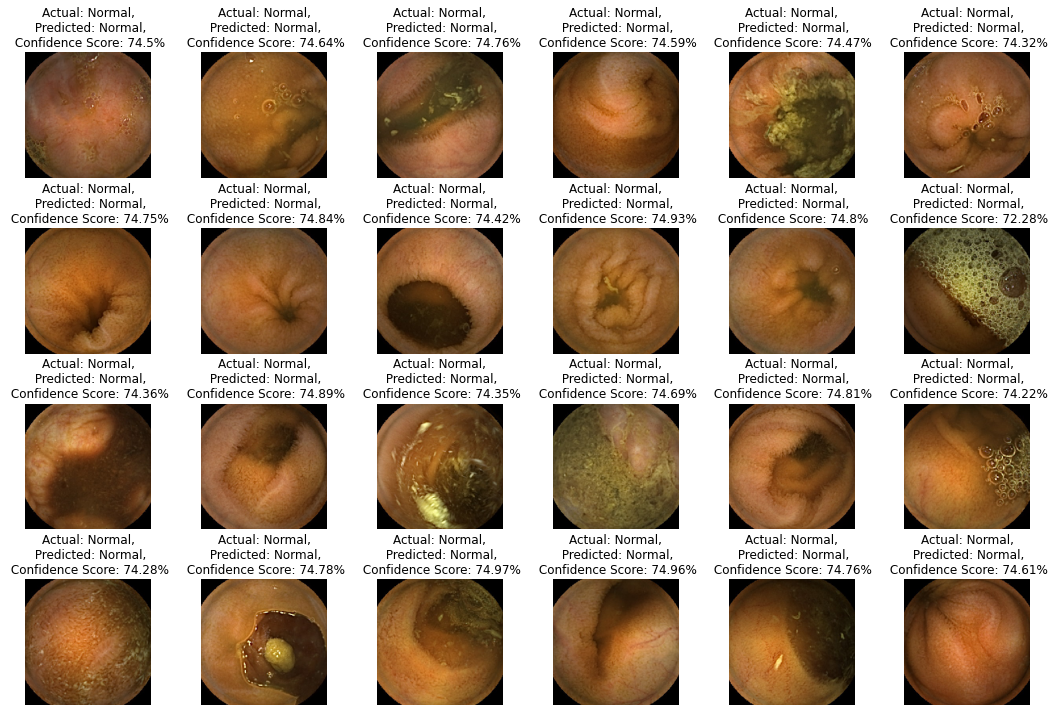

In [ ]:
BATCH_SIZE = 24
plt.figure(figsize=(18, 12))
for images, labels in normal_train_ds:
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, 6, i + 1)
        img = images[i]
        plt.imshow(img)
        actual_cls = 'Normal'  # since we only have images from the Normal class
        prediction = model.predict(img[np.newaxis, ...])
        predicted_cls = 'Normal'
        confidence = round(100 * (np.max(prediction)), 2)
        plt.title(f"Actual: {actual_cls},\n Predicted: {predicted_cls},\n Confidence Score: {confidence}%")
        plt.axis("off")
        plt.subplots_adjust(wspace=0.4)
        plt.subplots_adjust(hspace=0.4)

    break  # break after the first batch to avoid displaying too many images
plt.show()


1/1 [==============================] - 0s 29ms/step


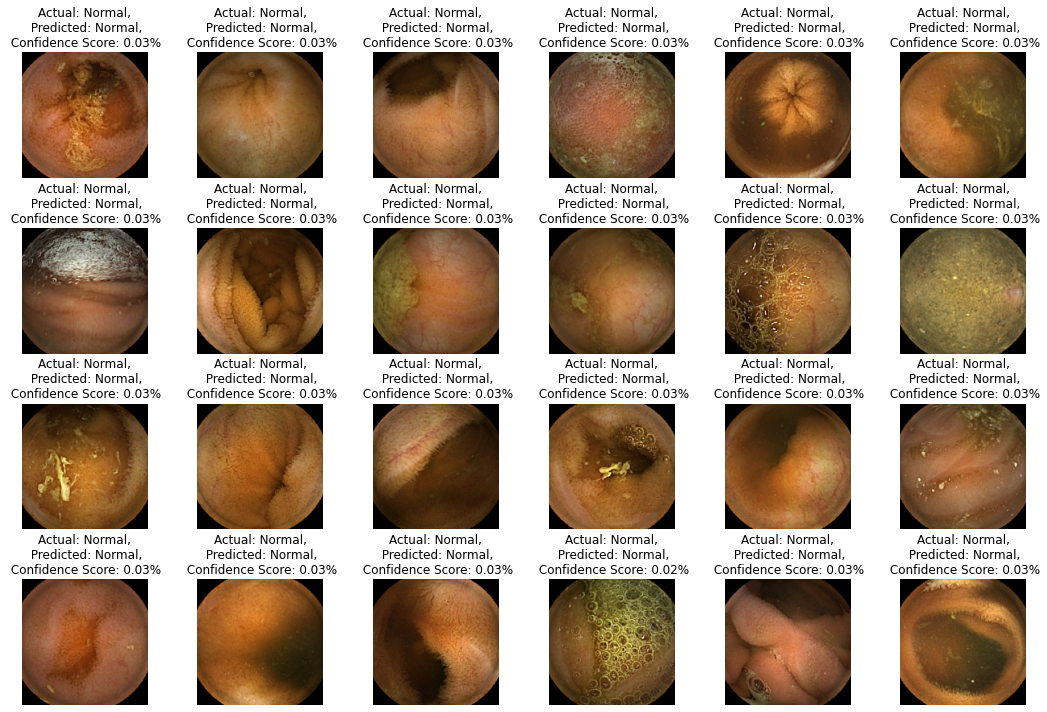

In [ ]:
BATCH_SIZE = 24
plt.figure(figsize=(18, 12))
for images, labels in normal_train_ds:
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, 6, i + 1)
        img = images[i]
        plt.imshow(img)
        actual_cls = 'Normal'  # since we only have images from the Normal class
        prediction = model.predict(img[np.newaxis, ...])
        confidence = round(100 * prediction[0][0], 2)
        plt.title(f"Actual: {actual_cls},\n Predicted: {predicted_cls},\n Confidence Score: {confidence}%")
        plt.axis("off")
        plt.subplots_adjust(wspace=0.4)
        plt.subplots_adjust(hspace=0.4)

    break  # break after the first batch to avoid displaying too many images
plt.show()


The reason why the confidence score is very low (0.03%) in the second code snippet is because it always predicts the class as "Normal" (as predicted_cls = 'Normal' is hardcoded). However, the model's actual prediction for the Normal class might be different than "Normal".

On the other hand, the first code snippet (confidence = round(100 * prediction[0][0], 2)) computes the confidence score for the Normal class based on the model's actual prediction for each image in the validation set. Therefore, it is a more accurate measure of the model's confidence in its predictions for the Normal class.

In [ ]:
# Get the predicted probabilities for the Normal class
probabilities = model.predict(normal_val_ds)

# Get the confidence score for each image
confidences = probabilities[:, 0]

# Print the confidence score for each image
for i, confidence in enumerate(confidences):
    print(f"Image {i+1}: {round(confidence*100, 2)}%")

10/10 [==============================] - 1s 106ms/step
Image 1: 0.03%
Image 2: 0.02%
Image 3: 0.03%
Image 4: 0.03%
Image 5: 0.03%
Image 6: 0.03%
Image 7: 0.03%
Image 8: 0.03%
Image 9: 0.03%
Image 10: 0.03%
Image 11: 0.03%
Image 12: 0.03%
Image 13: 0.03%
Image 14: 0.03%
Image 15: 0.03%
Image 16: 0.03%
Image 17: 0.03%
Image 18: 0.03%
Image 19: 0.03%
Image 20: 0.03%
Image 21: 0.03%
Image 22: 0.03%
Image 23: 0.03%
Image 24: 0.03%
Image 25: 0.03%
Image 26: 0.03%
Image 27: 0.03%
Image 28: 0.03%
Image 29: 0.03%
Image 30: 0.03%
Image 31: 0.03%
Image 32: 0.02%
Image 33: 0.03%
Image 34: 0.03%
Image 35: 0.03%
Image 36: 0.03%
Image 37: 0.03%
Image 38: 0.03%
Image 39: 0.03%
Image 40: 0.03%
Image 41: 0.02%
Image 42: 0.03%
Image 43: 0.03%
Image 44: 0.03%
Image 45: 0.03%
Image 46: 0.03%
Image 47: 0.03%
Image 48: 0.03%
Image 49: 0.03%
Image 50: 0.03%
Image 51: 0.03%
Image 52: 0.03%
Image 53: 0.03%
Image 54: 0.03%
Image 55: 0.03%
Image 56: 0.03%
Image 57: 0.02%
Image 58: 0.03%
Image 59: 0.03%
Image 60: 